# Extração de Informações Espectrais por Região de Interesse (ROI)

Neste notebook, vamos demonstrar como extrair informações espectrais a partir de bandas de imagem de satélite delimitadas por um polígono (shape). Essa técnica é amplamente utilizada em aplicações de sensoriamento remoto e análise ambiental, permitindo calcular estatísticas (como média, desvio padrão ou valores máximos/mínimos) apenas dentro de áreas de interesse, como bacias hidrográficas, áreas agrícolas ou regiões costeiras.

Ao longo dos próximos passos, utilizaremos bibliotecas como `geemap` e `earthengine-api` para realizar a sobreposição das bandas com o shape e extrair os dados relevantes.


In [1]:
import ee
import geemap
import geemap_tools as gee

ee.Authenticate()
ee.Initialize(project='ee-andrebelem') # << note que vc tem que mudar para o seu projeto

Obviamente vamos precisar de um ROI... 

In [2]:
# Carregando a FeatureCollection
dataset = ee.FeatureCollection('WCMC/WDPA/current/polygons')

# agora crio um ROI para o PESET
peset = dataset.filter(ee.Filter.eq("NAME", "Parque Estadual Da Serra Da Tiririca"))

Agora, vamos pegar uma imagem de interesse. Note que se você tem uma coleção, as operações adiante podem ser feitas dentro de um laço.

In [5]:
# Carrega a imagem Sentinel-2
image = ee.Image("COPERNICUS/S2_SR/20250117T130241_20250117T130244_T23KPQ")

# transforma o peset em image (só para desenhar a borda)
img_contorno = ee.Image().paint(
    featureCollection=peset,
    color=1,       # Valor de pixel (para visualização)
    width=2        # Largura da linha
)

# Seleciona bandas para true color
true_color = image.select(['B4', 'B3', 'B2'])

# Parâmetros de visualização
vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2'],
    'gamma': 1.3
}

# Cria o mapa e centraliza na ROI
Map = geemap.Map()
Map.centerObject(peset, zoom=13)
Map.addLayer(true_color, vis_params, "Sentinel-2 True Color")
# Adiciona ao mapa apenas o contorno
Map.addLayer(img_contorno, {'palette': 'red'}, "Contorno ROI")
Map.addLayerControl()
Map


Map(center=[-22.936059848900094, -43.0111785825978], controls=(WidgetControl(options=['position', 'transparent…

In [10]:
# agora, vamos listar as bandas da imagem

clipped = image.clip(peset) # primeiro vou clipar a imagem
bands = image.bandNames().getInfo()
print(bands)

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


Note que dei um "clip" na imagem porque não estou interessado em outras partes que não sejam dentro do ROI.

In [51]:
bands_of_interest = ['B4', 'B3', 'B2']
# Define resolução (em metros)
scale = 10

In [52]:
# Área da ROI em metros quadrados
area_m2 = peset.geometry().area().getInfo()

# Estimativa de número de pixels (1 pixel = scale x scale m²)
pixel_area = scale * scale
n_pixels = area_m2 / pixel_area

print(f"Área da ROI: {area_m2:.2f} m²")
print(f"Número estimado de pixels a {scale}m: {int(n_pixels)}")


Área da ROI: 34999681.60 m²
Número estimado de pixels a 10m: 349996


## Visualização Rápida da Distribuição de Valores em uma Banda

Uma das maneiras mais práticas e rápidas de verificar a distribuição de valores de uma banda específica dentro de uma Região de Interesse (ROI) é utilizando a função `feature_histogram()` da biblioteca `geemap`.

Essa função permite gerar um histograma dos valores da banda recortados pela geometria definida no shape (por exemplo, um polígono), facilitando a análise inicial dos dados, como detecção de outliers, identificação de padrões e definição de limiares para classificação.

No exemplo a seguir, aplicaremos o `feature_histogram()` sobre uma imagem e um polígono selecionado para visualizar a distribuição espectral da banda desejada.


In [39]:
import geemap.chart as chart
target = clipped.select(bands_of_interest).sample(peset)
chart.feature_histogram(target,'B2')

## Extração Direta de Valores com `aggregate_array`

Embora ferramentas como `feature_histogram()` sejam úteis para uma análise visual rápida, em muitos casos pode ser mais eficiente obter diretamente os valores dos pixels de uma banda dentro de um ROI utilizando o método `aggregate_array`, nativo do Earth Engine (`ee`).

Esse método retorna uma lista com todos os valores da banda dentro da geometria definida, o que permite maior controle sobre o processamento posterior, como cálculo de estatísticas personalizadas, remoção de valores nulos, ou aplicação de filtros.

In [53]:
pixels = target.aggregate_array('B4').getInfo() # note que demora um pouco

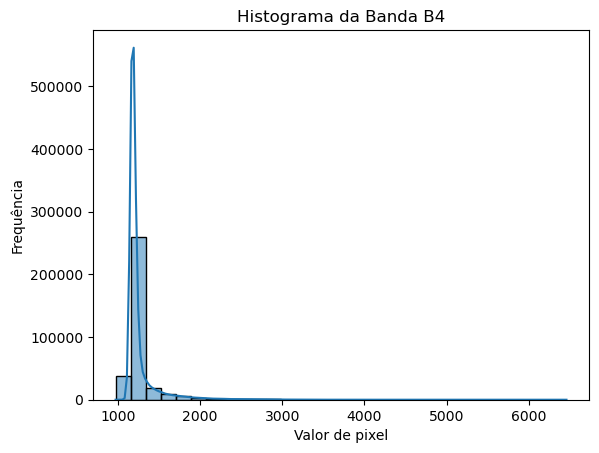

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cria histograma
sns.histplot(pixels, bins=30, kde=True)

# Personaliza e mostra
plt.xlabel("Valor de pixel")
plt.ylabel("Frequência")
plt.title("Histograma da Banda B4")
plt.show()


Note que eu posso buscar esses valores programaticamente ao longo de várias bandas...

In [58]:
from tqdm import tqdm
import pandas as pd
# Parâmetros de entrada
bands_of_interest = ['B4', 'B3', 'B2']  # Substitua pelas bandas desejadas
# Dicionário para guardar os arrays
band_data = {}

# Loop com tqdm
for band in tqdm(bands_of_interest, desc="Extraindo pixels por banda"):
    # Seleciona apenas a banda desejada
    band_img = target.select(band)

    # Usa aggregate_array para extrair todos os valores da banda
    values = band_img.aggregate_array(band).getInfo()

    # Armazena no dicionário
    band_data[band] = values

# Constrói o DataFrame
df_bandas = pd.DataFrame(band_data)

Extraindo pixels por banda: 100%|██████████████████████████████████████████████████| 3/3 [01:24<00:00, 28.22s/it]


### Análise dos Valores de Pixel por Banda

Agora que extraímos todos os valores de pixel para cada banda de interesse na nossa região de estudo (ROI), os dados estão organizados em colunas de um `DataFrame`, facilitando a visualização estatística.

Com isso, podemos:

- Plotar **histogramas** para analisar a distribuição de frequência dos valores espectrais por banda;
- Criar **boxplots** para visualizar a mediana, quartis, dispersão e detectar possíveis outliers.

Essas visualizações ajudam a entender a qualidade dos dados, identificar ruídos, saturações e possíveis efeitos de sombra ou cobertura de nuvens em determinadas bandas.


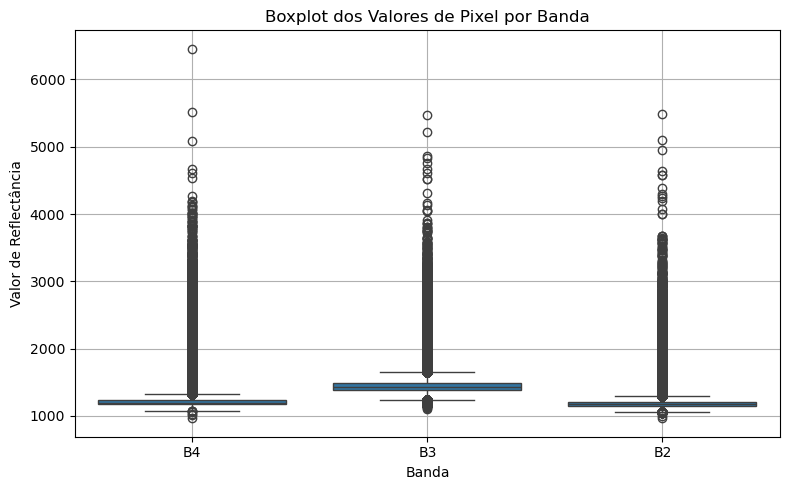

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que df contém colunas como 'B2', 'B3', 'B4'
df_melted = df_bandas.melt(var_name='Banda', value_name='Valor')

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_melted, x='Banda', y='Valor')
plt.title('Boxplot dos Valores de Pixel por Banda')
plt.xlabel('Banda')
plt.ylabel('Valor de Reflectância')
plt.grid(True)
plt.tight_layout()
plt.show()

### Fechamento do Exercício

Neste exercício, aprendemos como extrair valores de pixel de múltiplas bandas espectrais usando o Google Earth Engine e organizar os dados em um `DataFrame` no Python. A partir dessa base, conseguimos aplicar visualizações estatísticas com `Seaborn`, como:

- Histogramas para investigar a distribuição dos valores;
- Boxplots para detectar padrões, outliers e comparar bandas entre si.

Essas análises são fundamentais para entender a variabilidade espectral dentro de uma região de interesse e preparar os dados para aplicações como classificação, detecção de mudanças e cálculo de índices.

> *Para consolidar o aprendizado, experimente aplicar a mesma lógica em outra cena ou conjunto de bandas, e explore a relação entre elas com outras técnicas gráficas ou estatísticas.*
